In [1]:
import sys
import os

# Añadir la ruta raíz del proyecto al path de Python
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))


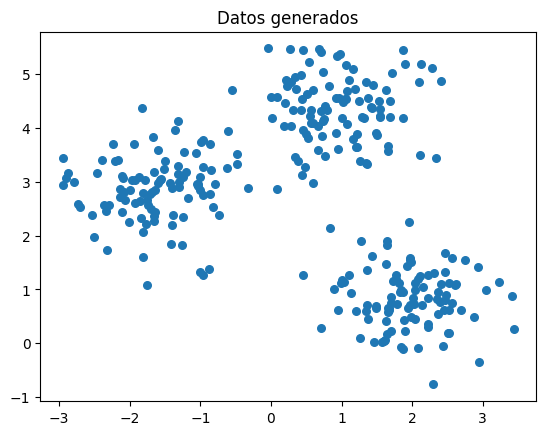

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

# Datos sintéticos con 3 clusters
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=30)
plt.title("Datos generados")
plt.show()


In [3]:
from src.gmm import GMM

# Usamos KMeans para inicialización
gmm_kmeans = GMM(n_components=3, init_method="kmeans", verbose=True)
gmm_kmeans.fit(X)
labels_kmeans = gmm_kmeans.predict(X)

# Ahora con inicialización aleatoria
gmm_random = GMM(n_components=3, init_method="random", verbose=True)
gmm_random.fit(X)
labels_random = gmm_random.predict(X)


Iter 0: log-likelihood = -994.8315
Iter 1: log-likelihood = -895.9146
Iter 2: log-likelihood = -866.7701
Iter 3: log-likelihood = -865.8858
Iter 4: log-likelihood = -865.8647
Iter 5: log-likelihood = -865.8631
Iter 6: log-likelihood = -865.8628
Iter 7: log-likelihood = -865.8627
Iter 0: log-likelihood = -1062.8929
Iter 1: log-likelihood = -1021.3898
Iter 2: log-likelihood = -977.8344
Iter 3: log-likelihood = -965.9617
Iter 4: log-likelihood = -965.7423
Iter 5: log-likelihood = -965.7021
Iter 6: log-likelihood = -965.6629
Iter 7: log-likelihood = -965.6147
Iter 8: log-likelihood = -965.5561
Iter 9: log-likelihood = -965.4875
Iter 10: log-likelihood = -965.4116
Iter 11: log-likelihood = -965.3325
Iter 12: log-likelihood = -965.2550
Iter 13: log-likelihood = -965.1835
Iter 14: log-likelihood = -965.1210
Iter 15: log-likelihood = -965.0683
Iter 16: log-likelihood = -965.0248
Iter 17: log-likelihood = -964.9890
Iter 18: log-likelihood = -964.9591
Iter 19: log-likelihood = -964.9335
Iter 20:

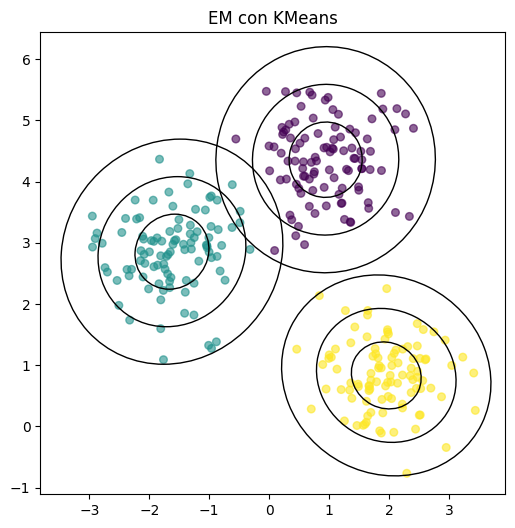

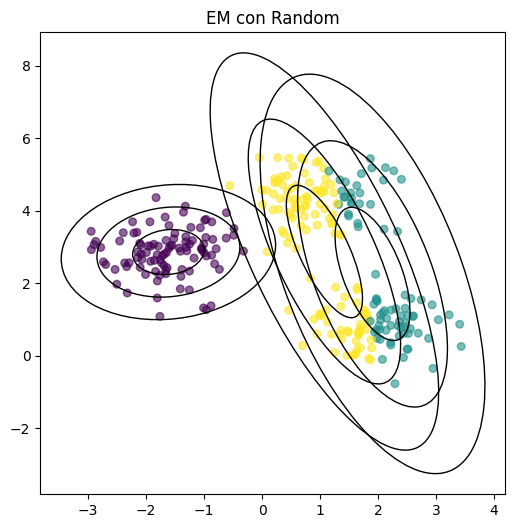

In [4]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def plot_clusters(X, labels, means, covariances, title="Clusters"):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap='viridis', alpha=0.6)

    for mean, cov in zip(means, covariances):
        draw_ellipse(mean, cov)

    plt.title(title)
    plt.show()

def draw_ellipse(mean, cov, ax=None, **kwargs):

    ax = ax or plt.gca()

    if cov.shape == (2, 2):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        for nsig in range(1, 4):
            width, height = 2 * nsig * np.sqrt(vals)
            ell = Ellipse(xy=mean, width=width, height=height,
                          angle=angle, edgecolor='black', facecolor='none', **kwargs)
            ax.add_patch(ell)

# Visualización
plot_clusters(X, labels_kmeans, gmm_kmeans.means_, gmm_kmeans.covariances_, title="EM con KMeans")
plot_clusters(X, labels_random, gmm_random.means_, gmm_random.covariances_, title="EM con Random")


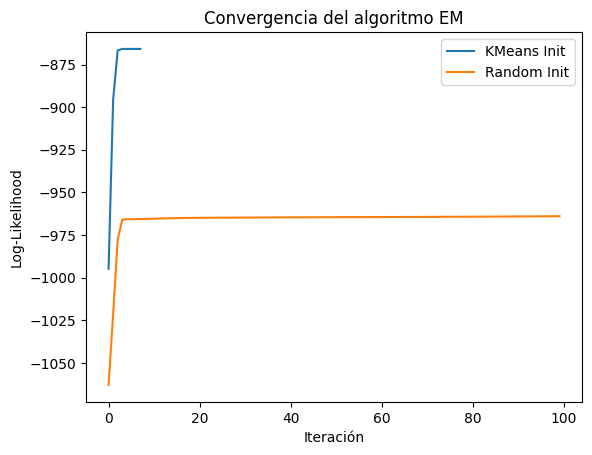

In [5]:
plt.plot(gmm_kmeans.log_likelihood_, label="KMeans Init")
plt.plot(gmm_random.log_likelihood_, label="Random Init")
plt.xlabel("Iteración")
plt.ylabel("Log-Likelihood")
plt.title("Convergencia del algoritmo EM")
plt.legend()
plt.show()


In [6]:
from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(y_true, labels_kmeans)
ari_random = adjusted_rand_score(y_true, labels_random)
print(ari_kmeans)
print(ari_random)

0.9899831669528851
0.5202281315270552


Running experiments: 100%|██████████| 10/10 [00:00<00:00, 12.37it/s]


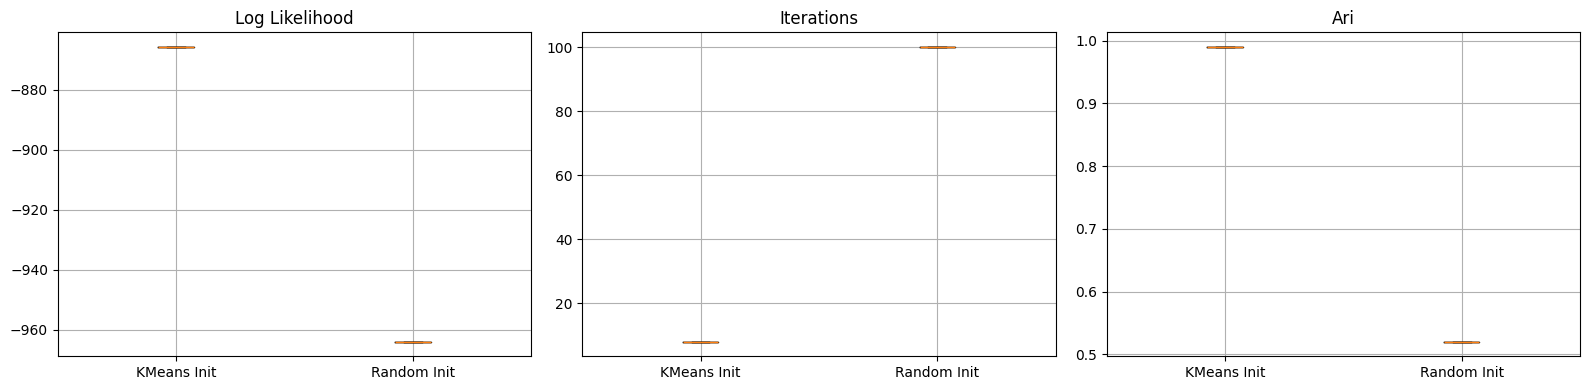

In [7]:
from src.evaluation import run_multiple_experiments, plot_results_comparison

results = run_multiple_experiments(X, y_true=y_true, n_runs=10, n_components=3)
plot_results_comparison(results)


| Métrica        | Resultado con KMeans | Resultado con Random     | Conclusión                         |
| -------------- | -------------------- | ------------------------ | ---------------------------------- |
| Log Likelihood | Alto, estable        | Bajo, peor ajuste        | KMeans da mejor punto de partida   |
| Iteraciones    | Rápida convergencia  | No converge en 100 pasos | Random no encuentra buen mínimo    |
| ARI            | \~1 (muy bueno)      | \~0.5 (malo)             | Clusters correctos solo con KMeans |


**Log-Likelihood**

The KMeans-initialized models consistently achieved higher log-likelihood values, indicating a better fit to the data. In contrast, random initialization often led to poor local optima with significantly lower log-likelihoods.

**Iterations**

Models initialized with KMeans converged quickly (typically within 10 iterations), while those initialized randomly failed to converge and hit the maximum iteration limit (100). This suggests poor parameter initialization hinders EM convergence.

**Adjusted Rand Index (ARI)**

The clustering quality measured by ARI was near perfect (~1.0) for KMeans initialization, accurately matching the true labels. Random initialization resulted in much worse clustering (ARI ~0.5), indicating unreliable performance.

In [8]:
import plotly.graph_objects as go
import numpy as np

def plot_gmm_interactive(X, labels, means, covariances, title="GMM Clustering (Interactive)"):
    fig = go.Figure()

    n_components = means.shape[0]

    # Añadir puntos
    fig.add_trace(go.Scatter(
        x=X[:, 0], y=X[:, 1],
        mode='markers',
        marker=dict(
            size=6,
            color=labels,
            colorscale='Viridis',
            opacity=0.7,
            line=dict(width=0)
        ),
        name="Data points"
    ))

    # Añadir elipses para cada componente
    for k in range(n_components):
        mean = means[k]
        cov = covariances[k]

        # Eigenvalues y eigenvectors para dibujar la elipse
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.arctan2(*vecs[:, 0][::-1])

        # Elipse paramétrica
        t = np.linspace(0, 2 * np.pi, 100)
        ellipse = np.array([np.cos(t), np.sin(t)])  # círculo unitario
        scale = 2.0  # factor de confianza (2σ ≈ 95%)
        ellipse = scale * np.sqrt(vals[:, np.newaxis]) * ellipse
        rot = vecs
        ellipse = rot @ ellipse + mean[:, np.newaxis]

        fig.add_trace(go.Scatter(
            x=ellipse[0], y=ellipse[1],
            mode='lines',
            line=dict(color='black', width=1),
            name=f"Component {k+1}"
        ))

        # Añadir centro
        fig.add_trace(go.Scatter(
            x=[mean[0]], y=[mean[1]],
            mode='markers',
            marker=dict(symbol='x', size=10, color='black'),
            name=f"Mean {k+1}",
            showlegend=False
        ))

    fig.update_layout(
        title=title,
        width=700,
        height=600,
        xaxis_title="X1",
        yaxis_title="X2",
        showlegend=True
    )

    fig.show()


In [9]:
labels = gmm_kmeans.predict(X)
plot_gmm_interactive(X, labels, gmm_kmeans.means_, gmm_kmeans.covariances_)


In [11]:
from src.visualization import plot_gmm_interactive, animate_em_history

# Visualización interactiva final
plot_gmm_interactive(X, gmm_kmeans.predict(X), gmm_kmeans.means_, gmm_kmeans.covariances_)

# Animación de iteraciones
anim = animate_em_history(X, gmm_kmeans.history_, max_frames=10)
from IPython.display import HTML
HTML(anim.to_jshtml())


In [ ]:
animate_em_history(X, gmm.history_, save_path="em_animation.gif")
